In [30]:
from elasticsearch import Elasticsearch, helpers
def greb_data_ES(index_name, size):
    es = Elasticsearch(
            "https://e32aaa94f81549368f75827f1e5da659.us-central1.gcp.cloud.es.io/",
            api_key=("g1i_hJIBR8AYR_FZHqsZ", "NgU5E6CkSJmd1t8uuljJJA"),
            timeout=60
            )
    print(es.info())
    response = es.search(
        index=index_name,
        body={
            "size": size,
            "_source": ["steamId", "tags", "genres", "features"],
            "query": {
                "match_all": {}
            }
        }
    )
    return response['hits']['hits']



In [2]:
import requests 
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re

In [ ]:

def get_last_month_avg(game_id):
    """
    Retrieve the average player count for the last 30 days for a given game from Steam Charts.

    Parameters:
    game_id : int or str
        The Steam app ID of the game.

    Returns:
    float or None
        The average player count over the last 30 days as a float, or None if the request fails.
    """
    # 目標 URL
    url = f"https://steamcharts.com/app/{game_id}"
    # 發送 GET 請求
    number_pattern = re.compile(r'\d+[\.,]?\d*')
    response = requests.get(url)
    print(response)
    if response.status_code == 200:
        # 解析 HTML
        soup = bs(response.text, 'html.parser')
        last_30_avg = soup.select('td.right.num-f.italic')[0]
        Match = re.search(number_pattern, last_30_avg.text.strip())
        print(float(Match.group()))
        return float(Match.group())
    else:
        return None
    
    

In [ ]:
def id_last_30_avg(rawdata):
    """
    Retrieve the last 30-day average player count for each game in the provided raw data and compile relevant information.

    Parameters:
    rawdata : list
        A list of dictionaries containing game data, each with keys "_source" (including "steamId", "tags", "genres", and "features").

    Returns:
    data_list : list
        A list of dictionaries, each containing:
        - "steamId": The Steam app ID of the game.
        - "last_30_avg": The average player count over the last 30 days.
        - "tags": Tags associated with the game.
        - "genres": Genres associated with the game.
        - "features": Features associated with the game.
    """
    data_list = []
    count = 0
    for item in rawdata:
        id = item["_source"]["steamId"]
        avg = get_last_month_avg(id)
        tags = item["_source"]["tags"]
        genres = item["_source"]["genres"]
        features = item["_source"]["features"]
        adds_up = {
            "steamId" : id,
            "last_30_avg" : avg,
            "tags" : tags,
            "genres" : genres,
            "features" : features
        }
        data_list.append(adds_up)
        count +=1
        print(count)
    return data_list

In [ ]:
game_rawdata = greb_data_ES('game_data_aaa', 752)
aaa_id_avg_online = id_last_30_avg(game_rawdata)


In [35]:
def ES_to_CSV(index, size):
    game_rawdata = greb_data_ES(index,size)
    id_avg_online = id_last_30_avg(game_rawdata)
    df = pd.DataFrame(id_avg_online)
    csv_path = f'../data/{index}_id_avg_online.csv'
    df.to_csv(csv_path, index=False)
    return df

In [ ]:
ES_to_CSV('game_data_aaa', 752)
ES_to_CSV('game_data_aa', 2694)
ES_to_CSV('game_data_indie', 36457)

In [10]:
df_aaa = pd.read_csv('../data/game_data_aaa_id_avg_online.csv')
df_aa = pd.read_csv('../data/game_data_aa_id_avg_online.csv')
df_indie = pd.read_csv('../data/game_data_indie_id_avg_online.csv')
df_combined = pd.concat([df_aaa, df_aa, df_indie], ignore_index=True)

In [30]:
def rm_free_game(df):
    df_filtered = df[~df['genres'].str.contains('Free To Play', na=False)]
    # df_filtered = df_filtered[~df_filtered['features'].str.contains('Free to Play', na=False)]
    df_filtered = df_filtered[~df_filtered['tags'].str.contains('Free to Play', na=False)]
    return df_filtered

In [31]:
print(df_aaa.shape)
print(df_aa.shape)
print(df_indie.shape)
print(df_combined.shape)

(752, 5)
(2694, 5)
(36457, 5)
(39903, 5)


In [32]:
df_aaa = rm_free_game(df_aaa)
df_aa = rm_free_game(df_aa)
df_indie = rm_free_game(df_indie)
df_combined = rm_free_game(df_combined)

In [33]:
print(df_aaa.shape)
print(df_aa.shape)
print(df_indie.shape)
print(df_combined.shape)

(692, 5)
(2538, 5)
(34236, 5)
(37466, 5)


In [5]:
def find_top_5_game(df, target):
    rows = df[df[target].apply(lambda x: 'Action' in x)]
    all = rows.sort_values(by='last_30_avg', ascending=False)[["steamId","last_30_avg"]]
    top5 = all.head(5)

    total_last_30_avg_all = all['last_30_avg'].sum()
    total_last_30_avg_top10 = top5['last_30_avg'].sum()
    top5.loc["other"] = ['other', total_last_30_avg_all-total_last_30_avg_top10]
    return top5

In [34]:
top5_aaa = find_top_5_game(df_aaa,'genres')
top5_aa = find_top_5_game(df_aa,'genres')
top5_indie = find_top_5_game(df_indie,'genres')
top5_combined = find_top_5_game(df_combined, 'genres')

/tmp/ipykernel_9345/3594276334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5.loc["other"] = ['other', total_last_30_avg_all-total_last_30_avg_top10]
/tmp/ipykernel_9345/3594276334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5.loc["other"] = ['other', total_last_30_avg_all-total_last_30_avg_top10]
/tmp/ipykernel_9345/3594276334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5.loc["other"] = ['other', total_

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_pie(top5): 
    plt.figure(figsize=(8, 8))
    plt.pie(top5['last_30_avg'], labels=top5['steamId'], autopct='%1.1f%%', startangle=90)
    plt.title('Last 30 Avg Distribution')
    plt.show()

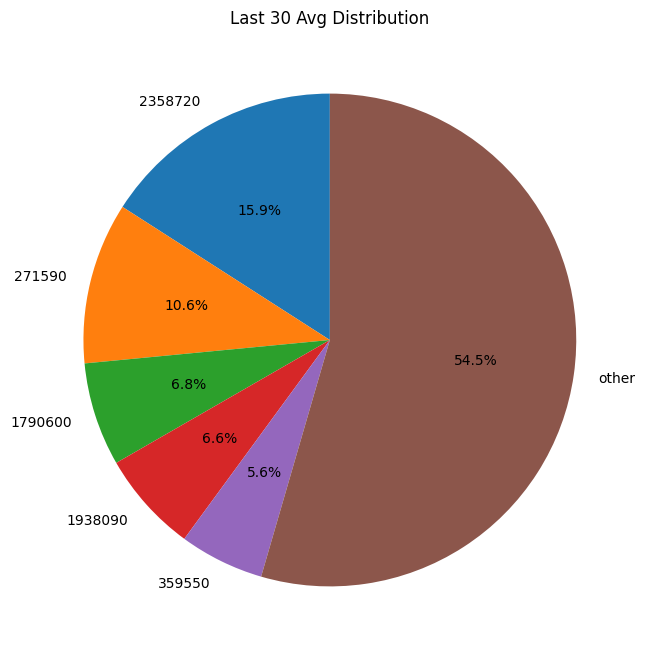

In [35]:
plot_pie(top5_aaa)

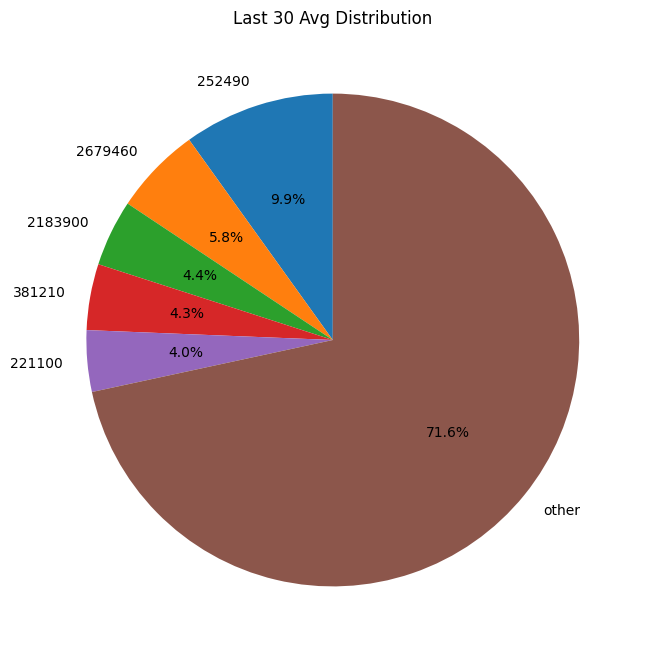

In [36]:
plot_pie(top5_aa)

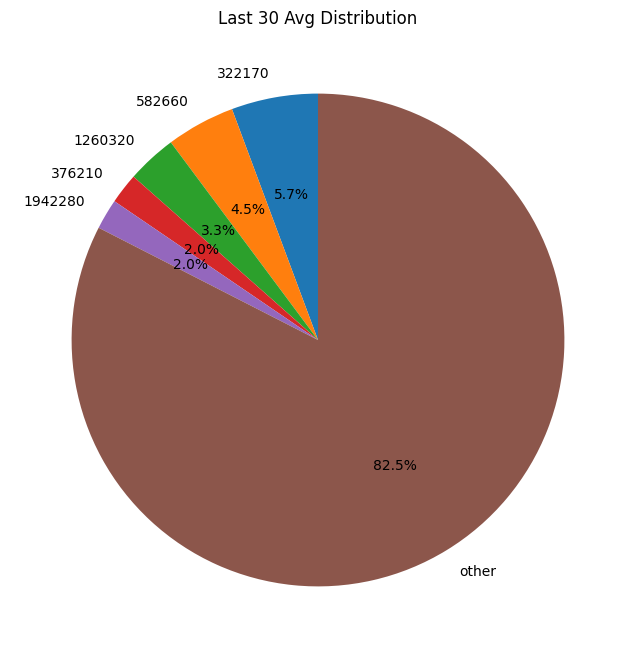

In [37]:
plot_pie(top5_indie)

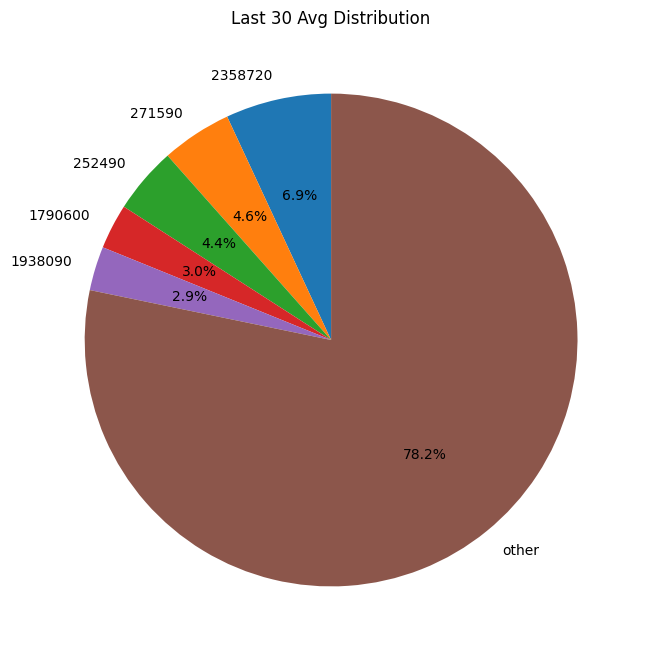

In [38]:
plot_pie(top5_combined)

In [ ]:
action_rows = df_aaa[df_aaa['genres'].apply(lambda x: 'Action' in x)]
all_aaa = action_rows.sort_values(by='last_30_avg', ascending=False)[["steamId","last_30_avg"]]
top5_aaa = all_aaa.head(5)

total_last_30_avg_all = all_aaa['last_30_avg'].sum()
total_last_30_avg_top10 = top5_aaa['last_30_avg'].sum()
top5_aaa.loc["other"] = ['other', total_last_30_avg_all-total_last_30_avg_top10]
top5_aaa

In [33]:
df_aa = pd.DataFrame(aa_id_avg_online)
df_aa

,steamId,last_30_avg,tags,genres,features
0,1623730,17761.43,"[Open World, Multiplayer, Survival, Creature C...","[Action, Adventure, Indie, RPG, Early Access]","[Single-player, Online Co-op, Steam Achievemen..."
1,252490,86785.44,"[Survival, Crafting, Multiplayer, Open World, ...","[Action, Adventure, Indie, Massively Multiplay...","[MMO, Online PvP, Online Co-op, Cross-Platform..."
2,236390,56107.13,"[Free to Play, Simulation, Vehicular Combat, C...","[Action, Massively Multiplayer, Simulation, Fr...","[Single-player, MMO, Online PvP, Online Co-op,..."
3,1203220,117832.63,"[Battle Royale, Multiplayer, Martial Arts, PvP...","[Action, Adventure, Massively Multiplayer]","[Online PvP, In-App Purchases]"
4,275850,10209.92,"[Open World, Open World Survival Craft, Space,...","[Action, Adventure]","[Single-player, Online PvP, Online Co-op, Cros..."
...,...,...,...,...,...
2689,1230170,10.04,"[Free to Play, Simulation, Gun Customization, ...",[Simulation],[Single-player]
2690,2902070,7.11,"[Simulation, Economy, Management, Casual, Sing...","[Casual, Indie, Simulation, Sports, Free To Play]",[Single-player]
2691,3110130,28.48,"[Simulation, Building, Automation, Resource Ma...","[Casual, Indie, Simulation, Free To Play]",[Single-player]
2692,3189460,NaN,"[Action, Adventure, Puzzle, 3D, First-Person, ...","[Action, Adventure, Indie, Free To Play]","[Single-player, Steam Achievements]"
